# FER2013 Facial Emotion Recognition - Complete Pipeline
## Dataset: **FER2013** with CNN Model Training & Evaluation

**This notebook covers the complete ML pipeline:**
1. Automatic dataset download (TensorFlow Datasets → fallback to Hugging Face `datasets`)  
2. Data inspection, preprocessing & augmentation
3. Train/validation/test splits with class balancing
4. CNN model architecture (EfficientNetV2-S based)
5. Model training with callbacks and monitoring
6. Comprehensive evaluation with metrics, charts, and confusion matrices
7. Model deployment preparation

## 1. Imports & Seed

In [3]:
# %%capture
# !pip install tensorflow-datasets datasets imbalanced-learn tqdm seaborn scikit-learn --upgrade

import os, json, random, itertools, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import tensorflow as tf
import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from collections import Counter
from tqdm import tqdm

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Enhanced GPU detection and diagnostics
print("=== GPU DETECTION & DIAGNOSTICS ===")
gpus = tf.config.list_physical_devices('GPU')
print(f"Physical GPU devices detected: {len(gpus)}")
has_gpu = len(gpus) > 0

if has_gpu:
    print("✅ GPU AVAILABLE - Optimizing for GPU training")
    # Configuration optimized for GPU
    IMG_SIZE = 224
    BATCH_SIZE = 32
    EPOCHS = 50
    LEARNING_RATE = 1e-4
    
    # Enable memory growth
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
        print(f"  GPU {gpu} - Memory growth enabled")
else:
    print("⚠️  NO GPU - Optimizing for CPU training")
    # Configuration optimized for CPU
    IMG_SIZE = 224        # Keep same size for model compatibility
    BATCH_SIZE = 16       # Smaller batch size for CPU
    EPOCHS = 5           # Fewer epochs for faster training
    LEARNING_RATE = 1e-4  # Same learning rate
    
    # Configure TensorFlow for optimal CPU performance
    tf.config.threading.set_intra_op_parallelism_threads(0)  # Use all CPU cores
    tf.config.threading.set_inter_op_parallelism_threads(0)  # Use all CPU cores
    print("  CPU optimization: Multi-threading enabled")

DATA_DIR = Path("./data_fer2013")
DATA_DIR.mkdir(parents=True, exist_ok=True)

print(f"\\n📋 TRAINING CONFIGURATION:")
print(f"   • TensorFlow version: {tf.__version__}")
print(f"   • Device: {'GPU' if has_gpu else 'CPU'}")
print(f"   • Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"   • Batch size: {BATCH_SIZE}")
print(f"   • Epochs: {EPOCHS}")
print(f"   • Learning rate: {LEARNING_RATE}")
if not has_gpu:
    print(f"   • CPU cores: {os.cpu_count()}")
    print(f"   • Estimated training time: ~2-3 hours")

print("\\n" + "="*50)

=== GPU DETECTION & DIAGNOSTICS ===
Physical GPU devices detected: 0
⚠️  NO GPU - Optimizing for CPU training
  CPU optimization: Multi-threading enabled
\n📋 TRAINING CONFIGURATION:
   • TensorFlow version: 2.15.0
   • Device: CPU
   • Image size: 224x224
   • Batch size: 16
   • Epochs: 5
   • Learning rate: 0.0001
   • CPU cores: 12
   • Estimated training time: ~2-3 hours
\n==================================================


## 2. Load Local FER2013 Dataset
The dataset is organized in the local `data_fer2013` folder with train/test splits and emotion class subdirectories.

In [4]:
def load_local_fer2013():
    """
    Load FER2013 dataset from local folder structure
    Expected structure: data_fer2013/train/{emotion}/*.jpg and data_fer2013/test/{emotion}/*.jpg
    """
    # Define emotion classes (in numerical order for consistency with original FER2013)
    CLASS_NAMES = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    
    # Create label mapping
    class_to_idx = {emotion: idx for idx, emotion in enumerate(CLASS_NAMES)}
    
    def load_images_from_folder(folder_path, split_name):
        """Load images and labels from folder structure"""
        images = []
        labels = []
        file_paths = []
        
        print(f"Loading {split_name} data...")
        
        for emotion in CLASS_NAMES:
            emotion_path = folder_path / emotion
            if not emotion_path.exists():
                print(f"Warning: {emotion_path} does not exist")
                continue
                
            emotion_images = list(emotion_path.glob('*.jpg'))
            print(f"  {emotion}: {len(emotion_images)} images")
            
            for img_path in tqdm(emotion_images, desc=f"Loading {emotion}"):
                try:
                    # Load and convert image to numpy array
                    img = Image.open(img_path).convert('L')  # Convert to grayscale
                    img_array = np.array(img)
                    
                    # Verify image shape (should be 48x48 for FER2013)
                    if img_array.shape == (48, 48):
                        images.append(img_array)
                        labels.append(class_to_idx[emotion])
                        file_paths.append(str(img_path))
                    else:
                        print(f"Skipping {img_path}: unexpected shape {img_array.shape}")
                        
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
        
        return images, labels, file_paths
    
    # Load training data
    train_images, train_labels, train_paths = load_images_from_folder(DATA_DIR / 'train', 'train')
    
    # Load test data
    test_images, test_labels, test_paths = load_images_from_folder(DATA_DIR / 'test', 'test')
    
    return (train_images, train_labels, train_paths), (test_images, test_labels, test_paths), CLASS_NAMES

# Load the local dataset
print("Loading FER2013 dataset from local files...")
(train_data, test_data, CLASS_NAMES) = load_local_fer2013()
train_images, train_labels, train_paths = train_data
test_images, test_labels, test_paths = test_data

print(f"\\nDataset loaded successfully!")
print(f"Training samples: {len(train_images)}")
print(f"Test samples: {len(test_images)}")
print(f"Classes: {CLASS_NAMES}")
print(f"Image shape: {train_images[0].shape if train_images else 'No images loaded'}")

Loading FER2013 dataset from local files...
Loading train data...
  angry: 3995 images


Loading angry: 100%|██████████| 3995/3995 [00:01<00:00, 3475.48it/s]


  disgust: 436 images


Loading disgust: 100%|██████████| 436/436 [00:00<00:00, 3570.94it/s]


  fear: 4097 images


Loading fear: 100%|██████████| 4097/4097 [00:01<00:00, 3527.40it/s]


  happy: 7215 images


Loading happy: 100%|██████████| 7215/7215 [00:01<00:00, 3627.51it/s]


  sad: 4830 images


Loading sad: 100%|██████████| 4830/4830 [00:01<00:00, 3546.16it/s]


  surprise: 3171 images


Loading surprise: 100%|██████████| 3171/3171 [00:00<00:00, 3552.76it/s]


  neutral: 4965 images


Loading neutral: 100%|██████████| 4965/4965 [00:01<00:00, 3632.27it/s]


Loading test data...
  angry: 958 images


Loading angry: 100%|██████████| 958/958 [00:00<00:00, 3630.44it/s]


  disgust: 111 images


Loading disgust: 100%|██████████| 111/111 [00:00<00:00, 3171.20it/s]


  fear: 1024 images


Loading fear: 100%|██████████| 1024/1024 [00:00<00:00, 3440.94it/s]


  happy: 1774 images


Loading happy: 100%|██████████| 1774/1774 [00:00<00:00, 3602.90it/s]


  sad: 1247 images


Loading sad: 100%|██████████| 1247/1247 [00:00<00:00, 3596.21it/s]


  surprise: 831 images


Loading surprise: 100%|██████████| 831/831 [00:00<00:00, 3694.41it/s]


  neutral: 1233 images


Loading neutral: 100%|██████████| 1233/1233 [00:00<00:00, 3580.45it/s]

\nDataset loaded successfully!
Training samples: 28709
Test samples: 7178
Classes: ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
Image shape: (48, 48)



## 3. Build a Pandas Manifest
We convert the dataset into a DataFrame so we can:  
- Inspect class distribution  
- Plot samples  
- Easily split & save manifests  


In [5]:
# Create pandas DataFrames from the loaded data
print("Creating pandas DataFrames...")

# Create training dataframe
train_df = pd.DataFrame({
    'image': train_images,
    'label': train_labels,
    'file_path': train_paths,
    'split': 'train'
})

# Create test dataframe  
test_df = pd.DataFrame({
    'image': test_images,
    'label': test_labels,
    'file_path': test_paths,
    'split': 'test'
})

# Create validation split from training data (10% of training data)
train_df, val_df = train_test_split(
    train_df, 
    test_size=0.1, 
    stratify=train_df['label'], 
    random_state=SEED
)

# Update split labels
val_df = val_df.copy()
val_df['split'] = 'val'

# Combine all data for analysis
full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

print(f"Final dataset splits:")
print(f"  Train: {len(train_df)} samples")
print(f"  Validation: {len(val_df)} samples") 
print(f"  Test: {len(test_df)} samples")
print(f"  Total: {len(full_df)} samples")

# Display first few samples
print(f"\\nDataFrame structure:")
print(full_df.head())

Creating pandas DataFrames...
Final dataset splits:
  Train: 25838 samples
  Validation: 2871 samples
  Test: 7178 samples
  Total: 35887 samples
\nDataFrame structure:
                                               image  label  \
0  [[253, 237, 70, 63, 58, 87, 107, 85, 65, 85, 8...      3   
1  [[76, 38, 48, 89, 82, 68, 65, 85, 123, 129, 11...      3   
2  [[82, 126, 109, 72, 62, 55, 78, 106, 132, 163,...      3   
3  [[16, 36, 59, 68, 75, 66, 69, 62, 75, 79, 88, ...      0   
4  [[229, 231, 233, 234, 235, 237, 239, 240, 241,...      3   

                                        file_path  split  
0  data_fer2013\train\happy\Training_42080017.jpg  train  
1  data_fer2013\train\happy\Training_93457887.jpg  train  
2  data_fer2013\train\happy\Training_80332648.jpg  train  
3  data_fer2013\train\angry\Training_78580098.jpg  train  
4  data_fer2013\train\happy\Training_54710808.jpg  train  



## 4. Sanity Checks
- Shape of images  
- Class distribution per split  
- Example visuals  


Sampled image shapes: Counter({(48, 48): 2000})


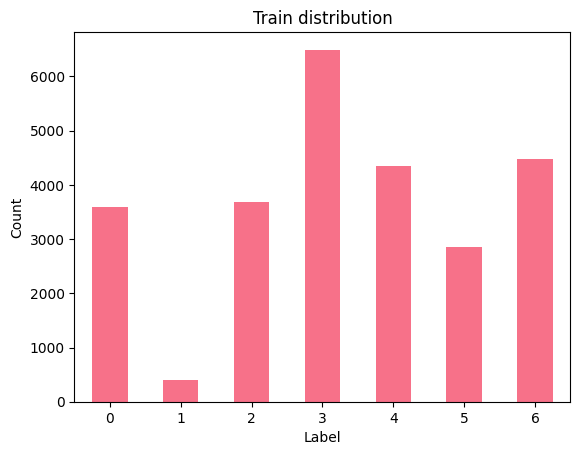

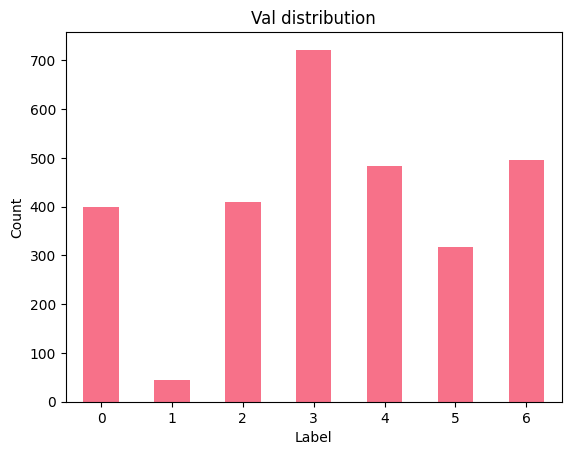

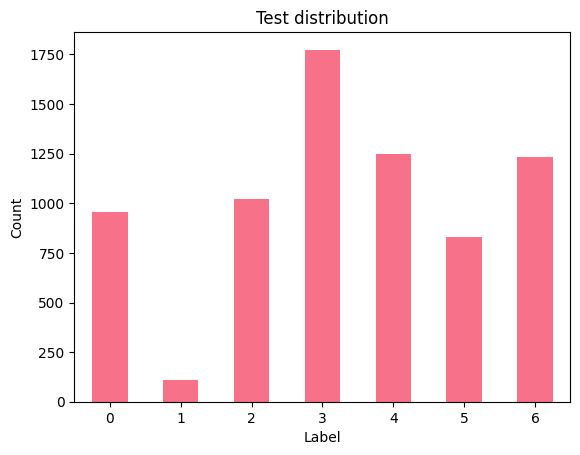

In [6]:

# Shapes
unique_shapes = Counter([tuple(img.shape) for img in full_df["image"].iloc[:2000]])
print("Sampled image shapes:", unique_shapes)

# Distribution
def plot_dist(df, title):
    counts = df['label'].value_counts().sort_index()
    plt.figure()
    counts.plot(kind='bar', rot=0)
    plt.title(title)
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.show()

plot_dist(train_df, "Train distribution")
plot_dist(val_df,   "Val distribution")
plot_dist(test_df,  "Test distribution")


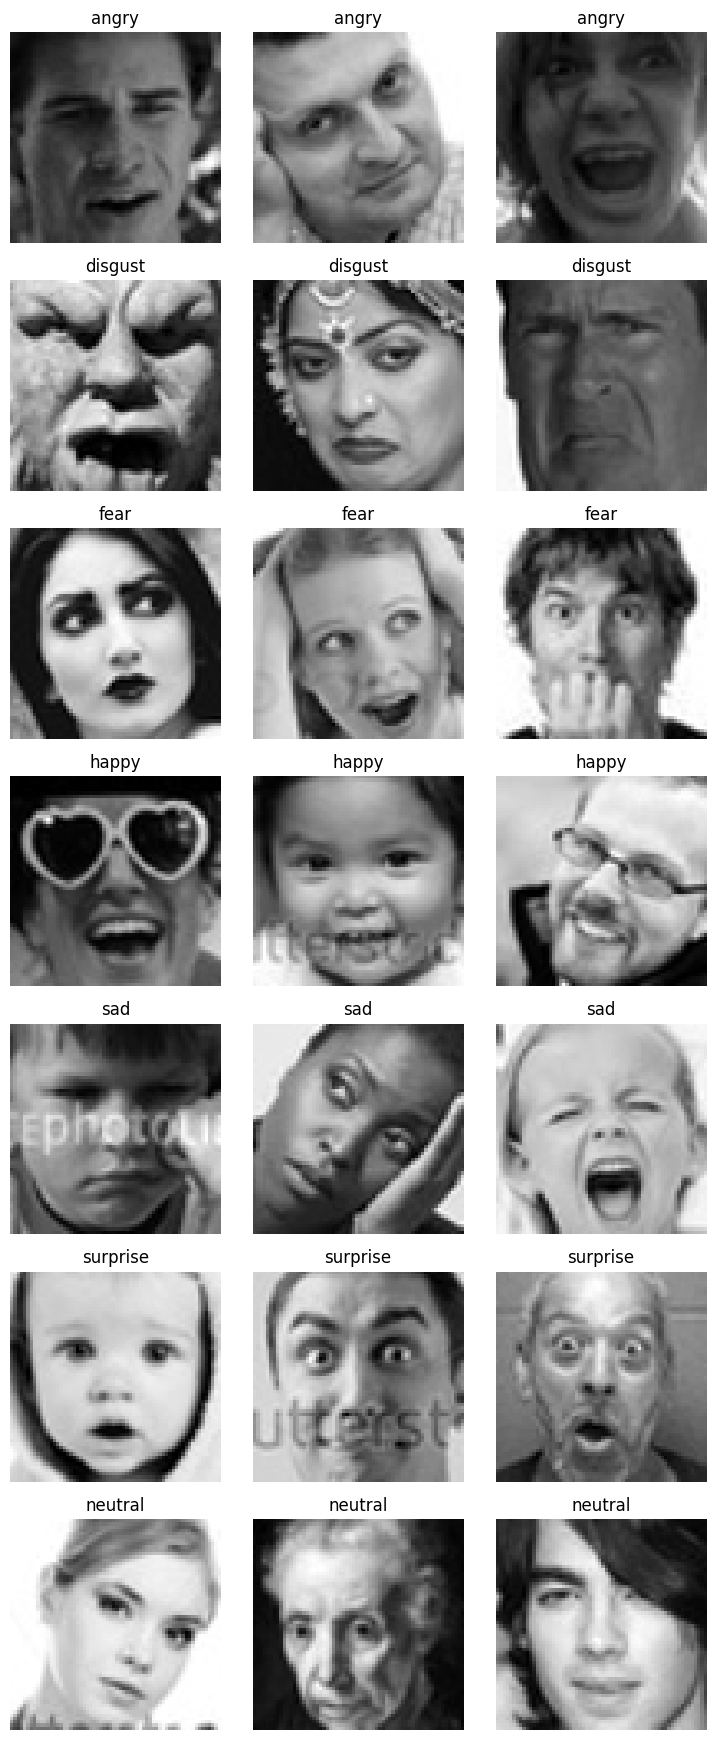

In [7]:

# Show samples
def show_samples(df, class_names, n_per_class=3, size=(64,64)):
    classes = sorted(df['label'].unique())
    samples = []
    for c in classes:
        sub = df[df['label']==c]
        samples.extend(sub.sample(min(n_per_class, len(sub)), random_state=SEED).to_dict('records'))
    cols = n_per_class
    rows = int(np.ceil(len(samples)/cols))
    plt.figure(figsize=(cols*2.5, rows*2.5))
    for i, rec in enumerate(samples):
        img = Image.fromarray(rec['image']).resize(size)
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img, cmap='gray')
        name = class_names[rec['label']] if rec['label'] < len(class_names) else rec['label']
        ax.set_title(name)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_samples(train_df, CLASS_NAMES, n_per_class=3)



## 5. Preprocessing Pipelines

### Common steps
- **Resize** to 48×48 or upscale to 224×224 for modern CNNs.  
- **Normalize** (mean/std from ImageNet or dataset-specific).  
- **Augment** (train only): random crop/flip/brightness.  

Below we build two pipelines:
1. **TensorFlow/Keras** using `tf.data`  
2. **PyTorch** using `Dataset` + `DataLoader`


### 5.1 TensorFlow / Keras pipeline

In [8]:
# Enhanced preprocessing with class weights calculation
def tf_preprocess(image, label, training=False):
    # Convert grayscale to RGB and resize
    image = tf.convert_to_tensor(image, dtype=tf.uint8)
    image = tf.image.resize(image[..., tf.newaxis], (IMG_SIZE, IMG_SIZE))
    image = tf.image.grayscale_to_rgb(image)
    
    # Data augmentation for training (simplified for compatibility)
    if training:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, 0.2)
        image = tf.image.random_contrast(image, 0.8, 1.2)
        image = tf.image.random_saturation(image, 0.8, 1.2)
    
    # Normalize to [0,1] then apply ImageNet normalization
    image = tf.cast(image, tf.float32) / 255.0
    mean = tf.constant([0.485, 0.456, 0.406])
    std  = tf.constant([0.229, 0.224, 0.225])
    image = (image - mean) / std
    
    return image, label

def df_to_tf_dataset(df, training=False):
    imgs = df['image'].tolist()
    labels = df['label'].tolist()
    ds = tf.data.Dataset.from_tensor_slices((imgs, labels))
    ds = ds.map(lambda x,y: tf_preprocess(x,y,training=training),
                num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(2048, seed=SEED)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

# Create datasets
tf_train_ds = df_to_tf_dataset(train_df, training=True)
tf_val_ds   = df_to_tf_dataset(val_df,   training=False)
tf_test_ds  = df_to_tf_dataset(test_df,  training=False)

# Calculate class weights for imbalanced dataset
class_counts = train_df['label'].value_counts().sort_index()
total_samples = len(train_df)
class_weights = {i: total_samples / (len(CLASS_NAMES) * count) 
                for i, count in enumerate(class_counts)}

print(f"Dataset sizes: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")
print(f"Class weights: {class_weights}")
print(f"Batch shape example: {next(iter(tf_train_ds))[0].shape}")

Dataset sizes: Train=25838, Val=2871, Test=7178
Class weights: {0: 1.026457969172096, 1: 9.416180758017493, 2: 1.0011236390406448, 3: 0.5684803414666344, 4: 0.8491241907390976, 5: 1.2933226549204124, 6: 0.8259438033436691}
Batch shape example: (16, 224, 224, 3)


## 6. CNN Model Architecture

In [9]:
def create_emotion_model(num_classes=7, img_size=224):
    """
    Create EfficientNetV2-S based model for emotion recognition using tf.keras
    """
    # Input layer
    inputs = tf.keras.layers.Input(shape=(img_size, img_size, 3))
    
    # Base model - EfficientNetV2S pretrained on ImageNet
    base_model = tf.keras.applications.EfficientNetV2S(
        input_tensor=inputs,
        weights='imagenet',
        include_top=False,
        pooling='avg'
    )
    
    # Freeze base model initially for transfer learning
    base_model.trainable = False
    
    # Custom head for emotion classification
    x = base_model.output
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(512, activation='relu', 
                             kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(256, activation='relu', 
                             kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax', name='emotion_output')(x)
    
    model = tf.keras.Model(inputs, outputs, name='EfficientNetV2S_Emotion')
    
    return model

# Create the model
model = create_emotion_model(num_classes=len(CLASS_NAMES), img_size=IMG_SIZE)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=LEARNING_RATE, weight_decay=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy', 'sparse_top_k_categorical_accuracy']
)

# Model summary
model.summary()



Model: "EfficientNetV2S_Emotion"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 24)         648       ['rescaling[0][0]']           
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 112, 112, 24)         96        ['stem_conv[0][0]']           
 n)                                                                       

## 7. Model Training with Callbacks

In [10]:
# Save cleaned data manifests and metadata for reproducibility
print("Saving dataset manifests...")

# Save the complete dataset manifest
manifest_path = Path("fer2013_local_manifest.parquet")
full_df_save = full_df.copy()

# Remove the actual image data to save space, keep metadata
full_df_save['image_shape'] = full_df_save['image'].apply(lambda x: x.shape)
full_df_save['image_dtype'] = full_df_save['image'].apply(lambda x: str(x.dtype))
full_df_save = full_df_save.drop('image', axis=1)  # Remove large image arrays

full_df_save.to_parquet(manifest_path, index=False)

# Save class names and metadata
metadata = {
    'dataset_source': 'local_fer2013',
    'class_names': CLASS_NAMES,
    'num_classes': len(CLASS_NAMES),
    'dataset_splits': {
        'train': len(train_df),
        'validation': len(val_df), 
        'test': len(test_df),
        'total': len(full_df)
    },
    'image_properties': {
        'shape': list(train_images[0].shape) if train_images else None,
        'dtype': str(train_images[0].dtype) if train_images else None,
        'color_mode': 'grayscale'
    },
    'data_location': str(DATA_DIR.resolve())
}

with open("fer2013_dataset_info.json", "w") as f:
    json.dump(metadata, f, indent=2)

print(f"Dataset manifest saved: {manifest_path.resolve()}")
print(f"Dataset metadata saved: fer2013_dataset_info.json")
print(f"\\nDataset summary:")
for split, count in metadata['dataset_splits'].items():
    if split != 'total':
        print(f"  {split.capitalize()}: {count:,} samples")
print(f"  Total: {metadata['dataset_splits']['total']:,} samples")

Saving dataset manifests...
Dataset manifest saved: D:\Documents\Msc of Data Science\2025\SIT_782_TPB\fer2013_local_manifest.parquet
Dataset metadata saved: fer2013_dataset_info.json
\nDataset summary:
  Train: 25,838 samples
  Validation: 2,871 samples
  Test: 7,178 samples
  Total: 35,887 samples


In [11]:
# Setup callbacks for training
checkpoint_path = "best_emotion_model.keras"  # Changed from .h5 to .keras

callback_list = [
    tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.CSVLogger('training_log.csv', append=True)
]

# Train the model
print("Starting training...")
history = model.fit(
    tf_train_ds,
    epochs=EPOCHS,
    validation_data=tf_val_ds,
    class_weight=class_weights,
    callbacks=callback_list,
    verbose=1
)

# Load best weights
model.load_weights(checkpoint_path)
print("Training completed. Best model loaded.")

Starting training...
Epoch 1/5




1615/1615 [==============================] - ETA: 0s - loss: 3.6071 - accuracy: 0.1547 - sparse_top_k_categorical_accuracy: 0.7434
Epoch 1: val_accuracy improved from -inf to 0.16162, saving model to best_emotion_model.keras
1615/1615 [==============================] - 607s 369ms/step - loss: 3.6071 - accuracy: 0.1547 - sparse_top_k_categorical_accuracy: 0.7434 - val_loss: 3.0340 - val_accuracy: 0.1616 - val_sparse_top_k_categorical_accuracy: 0.7809 - lr: 1.0000e-04
Epoch 2/5
1615/1615 [==============================] - ETA: 0s - loss: 3.3288 - accuracy: 0.1641 - sparse_top_k_categorical_accuracy: 0.7562
Epoch 2: val_accuracy improved from 0.16162 to 0.18600, saving model to best_emotion_model.keras
1615/1615 [==============================] - 600s 371ms/step - loss: 3.3288 - accuracy: 0.1641 - sparse_top_k_categorical_accuracy: 0.7562 - val_loss: 2.9257 - val_accuracy: 0.1860 - val_sparse_top_k_categorical_accuracy: 0.8300 - lr: 1.0000e-04
Epoch 3/5
1615/1615 [======================

## 9. Comprehensive Model Evaluation

## 10. Model Deployment and Fine-tuning

In [12]:
# Optional: Fine-tune the pre-trained model
def fine_tune_model(model, train_ds, val_ds, epochs=10):
    """
    Fine-tune the pre-trained model by unfreezing some layers
    """
    print("Starting fine-tuning phase...")
    
    # Unfreeze the top layers of the base model
    base_model = model.layers[1]  # EfficientNetV2S layer
    base_model.trainable = True
    
    # Freeze all layers except the last few
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    
    # Recompile with lower learning rate
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=LEARNING_RATE/10, weight_decay=0.0001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy', 'sparse_top_k_categorical_accuracy']
    )
    
    # Fine-tuning callbacks
    finetune_callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.3,
            patience=3,
            min_lr=1e-8,
            verbose=1
        )
    ]
    
    # Fine-tune
    history_ft = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        callbacks=finetune_callbacks,
        verbose=1
    )
    
    return history_ft

# Uncomment to run fine-tuning
# history_finetune = fine_tune_model(model, tf_train_ds, tf_val_ds, epochs=15)

# Save the final model
model.save('fer2013_emotion_model.keras')  # Changed from .h5 to .keras
model.save('fer2013_emotion_model', save_format='tf')  # SavedModel format

# Save model weights separately (weights can still use .h5)
model.save_weights('fer2013_model_weights.h5')

print("Model saved successfully!")
print("Files created:")
print("- fer2013_emotion_model.keras (Keras format)")
print("- fer2013_emotion_model/ (TensorFlow SavedModel)")
print("- fer2013_model_weights.h5 (weights only)")

# Save metadata and results
metadata = {
    'model_architecture': 'EfficientNetV2S',
    'input_shape': [IMG_SIZE, IMG_SIZE, 3],
    'num_classes': len(CLASS_NAMES),
    'class_names': CLASS_NAMES,
    'training_config': {
        'batch_size': BATCH_SIZE,
        'epochs': EPOCHS,
        'learning_rate': LEARNING_RATE,
        'img_size': IMG_SIZE
    },
    'dataset_info': {
        'train_size': len(train_df),
        'val_size': len(val_df),
        'test_size': len(test_df)
    }
}

with open('model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("\\nModel metadata saved to 'model_metadata.json'")

INFO:tensorflow:Assets written to: fer2013_emotion_model\assets


INFO:tensorflow:Assets written to: fer2013_emotion_model\assets


Model saved successfully!
Files created:
- fer2013_emotion_model.keras (Keras format)
- fer2013_emotion_model/ (TensorFlow SavedModel)
- fer2013_model_weights.h5 (weights only)
\nModel metadata saved to 'model_metadata.json'


## 11. Sample Predictions and Error Analysis

Generating sample predictions...


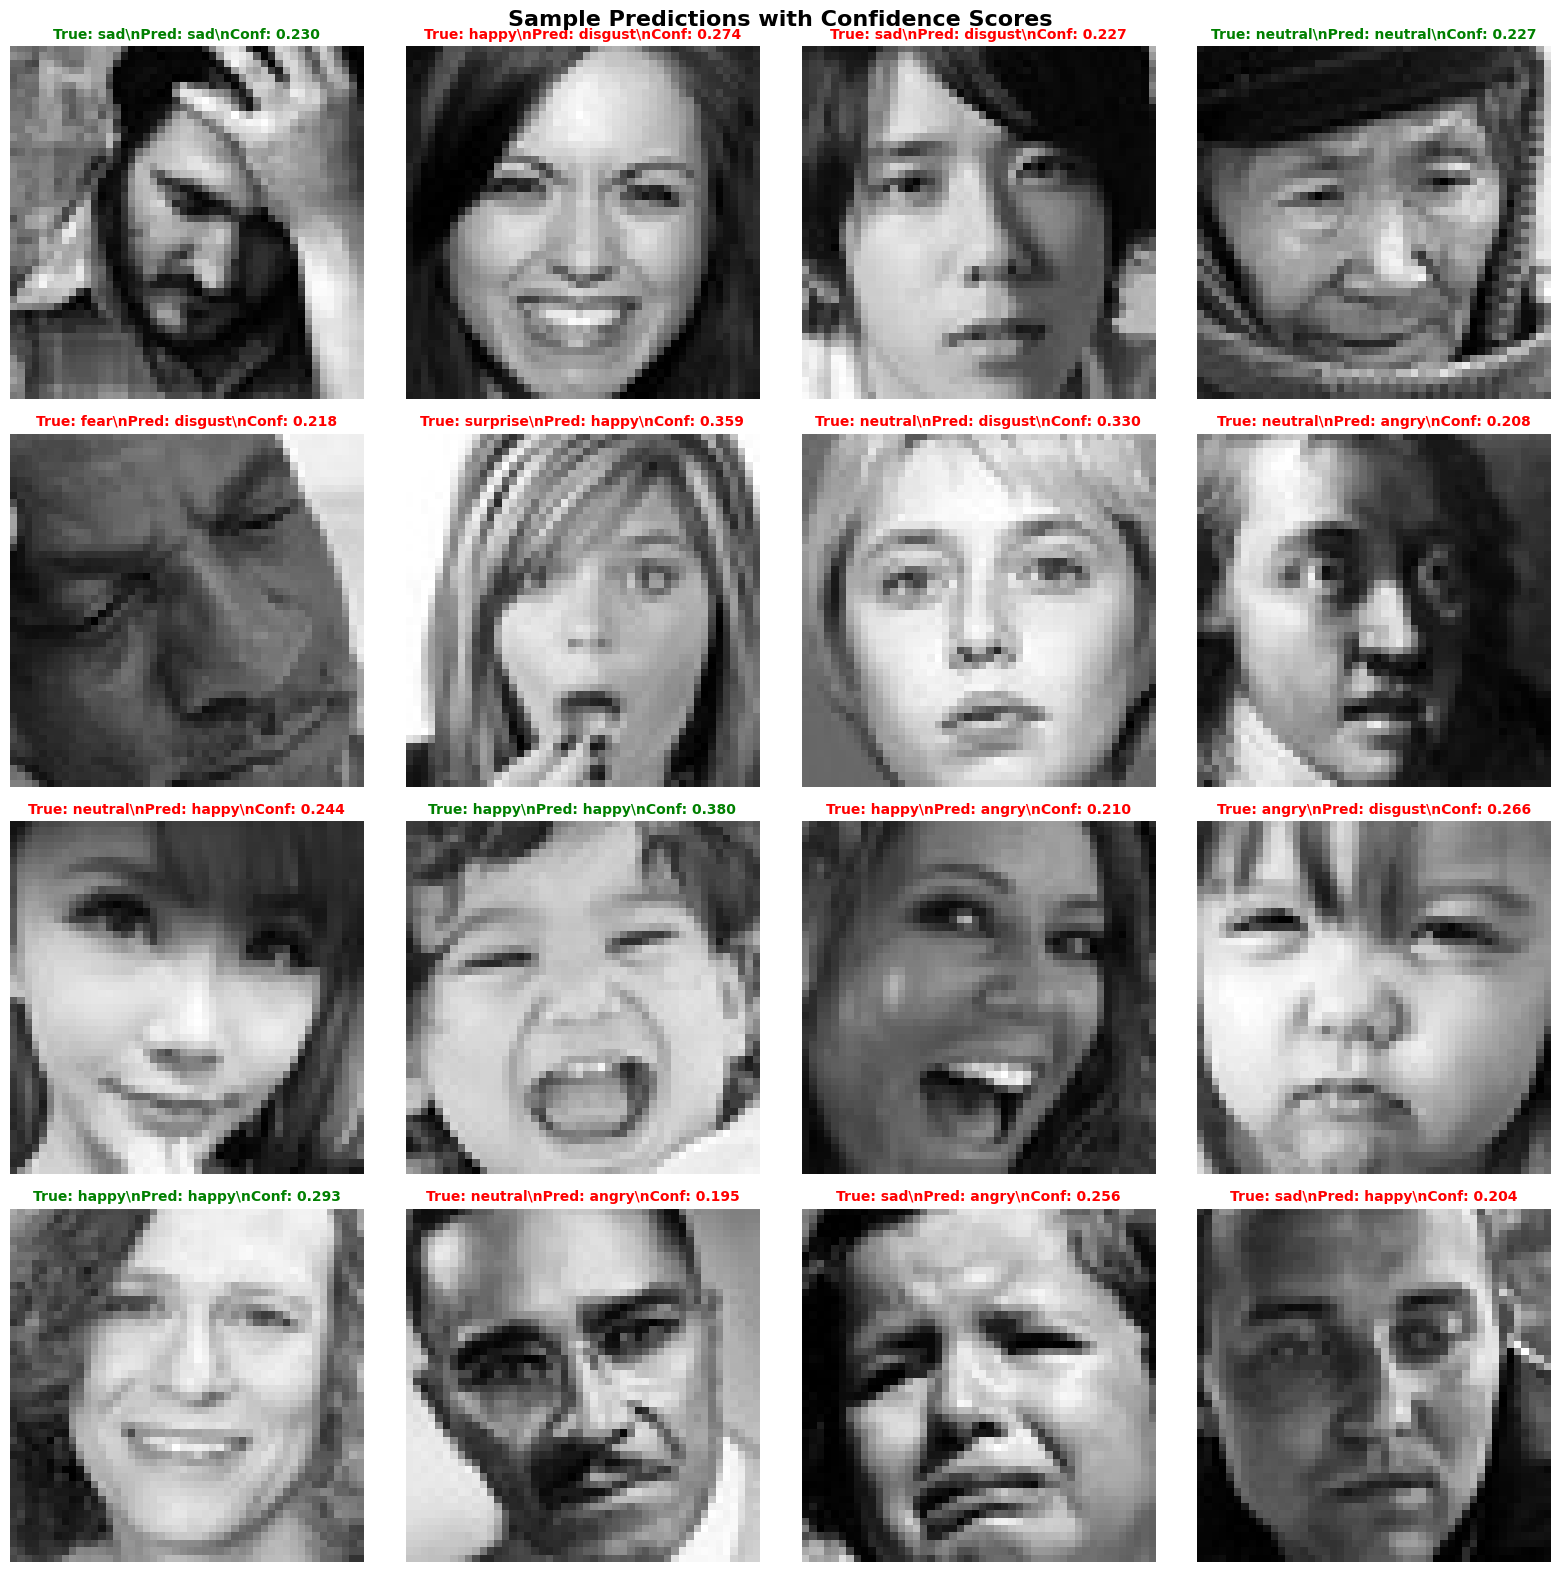

\nAnalyzing difficult cases...


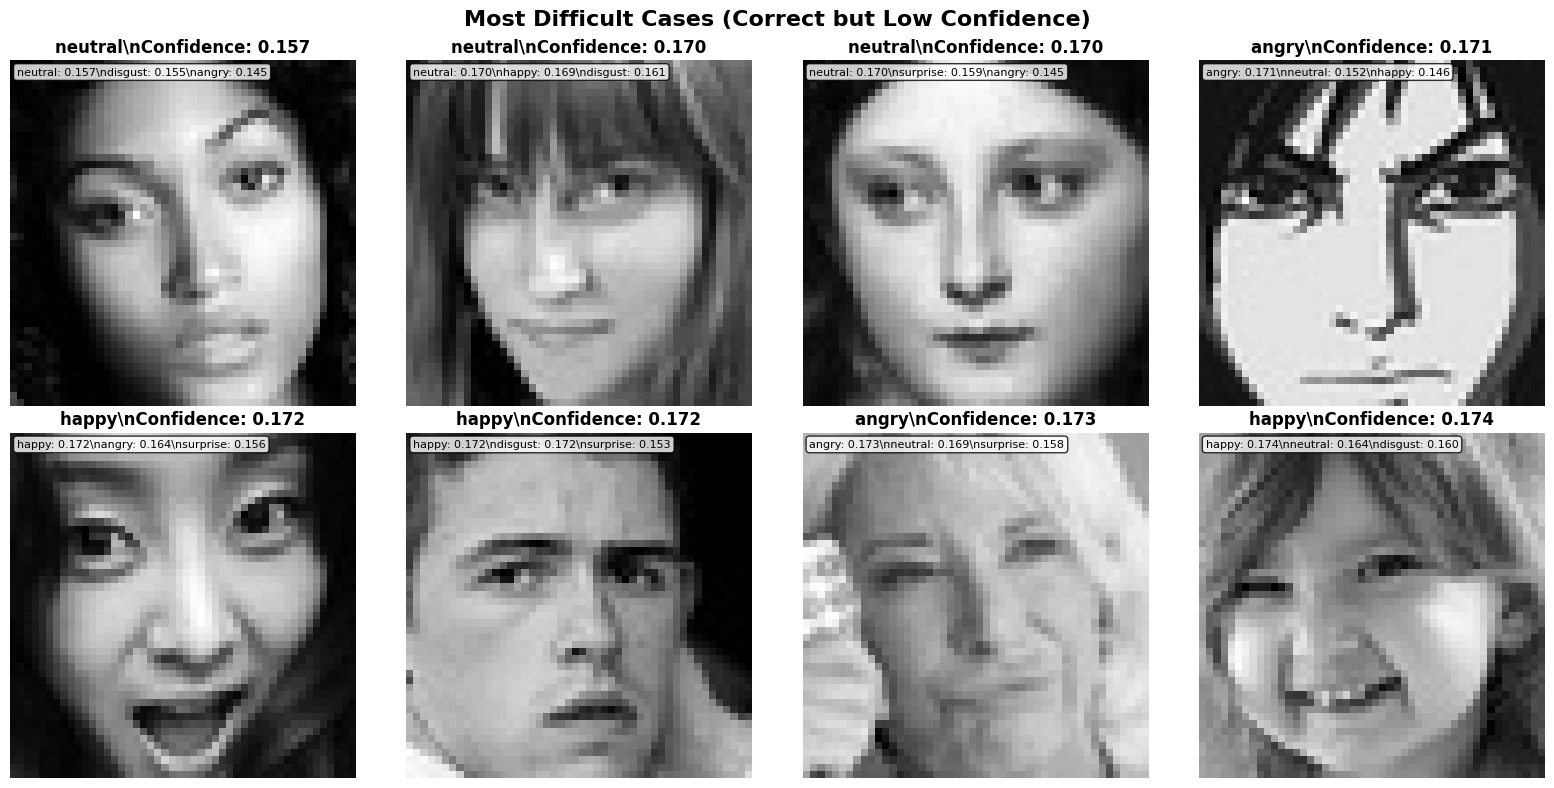

In [13]:
def visualize_predictions(model, test_df, class_names, n_samples=16):
    """
    Visualize sample predictions with confidence scores
    """
    # Select random samples
    sample_indices = np.random.choice(len(test_df), n_samples, replace=False)
    
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    axes = axes.flatten()
    
    for i, idx in enumerate(sample_indices):
        img = test_df.iloc[idx]['image']
        true_label = test_df.iloc[idx]['label']
        
        # Preprocess image for prediction
        img_processed = tf_preprocess(img, true_label, training=False)[0]
        img_batch = tf.expand_dims(img_processed, 0)
        
        # Get prediction
        pred_probs = model.predict(img_batch, verbose=0)[0]
        pred_class = np.argmax(pred_probs)
        confidence = pred_probs[pred_class]
        
        # Display image
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        
        # Title with prediction info
        true_emotion = class_names[true_label]
        pred_emotion = class_names[pred_class]
        color = 'green' if pred_class == true_label else 'red'
        
        title = f'True: {true_emotion}\\nPred: {pred_emotion}\\nConf: {confidence:.3f}'
        axes[i].set_title(title, fontsize=10, color=color, fontweight='bold')
    
    plt.suptitle('Sample Predictions with Confidence Scores', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def analyze_difficult_cases(model, test_df, class_names, n_cases=8):
    """
    Analyze the most difficult cases (lowest confidence correct predictions)
    """
    # Get all predictions
    predictions = []
    for idx in range(len(test_df)):
        img = test_df.iloc[idx]['image']
        true_label = test_df.iloc[idx]['label']
        
        img_processed = tf_preprocess(img, true_label, training=False)[0]
        img_batch = tf.expand_dims(img_processed, 0)
        pred_probs = model.predict(img_batch, verbose=0)[0]
        
        predictions.append({
            'idx': idx,
            'true_label': true_label,
            'pred_class': np.argmax(pred_probs),
            'confidence': pred_probs[np.argmax(pred_probs)],
            'pred_probs': pred_probs
        })
    
    # Find correct predictions with lowest confidence
    correct_preds = [p for p in predictions if p['true_label'] == p['pred_class']]
    difficult_cases = sorted(correct_preds, key=lambda x: x['confidence'])[:n_cases]
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i, case in enumerate(difficult_cases):
        idx = case['idx']
        img = test_df.iloc[idx]['image']
        true_label = case['true_label']
        confidence = case['confidence']
        pred_probs = case['pred_probs']
        
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        
        emotion = class_names[true_label]
        title = f'{emotion}\\nConfidence: {confidence:.3f}'
        axes[i].set_title(title, fontsize=12, fontweight='bold')
        
        # Show top 3 predictions as text
        top3_idx = np.argsort(pred_probs)[-3:][::-1]
        prob_text = '\\n'.join([f'{class_names[j]}: {pred_probs[j]:.3f}' for j in top3_idx])
        axes[i].text(0.02, 0.98, prob_text, transform=axes[i].transAxes, 
                    verticalalignment='top', fontsize=8, 
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.suptitle('Most Difficult Cases (Correct but Low Confidence)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Run prediction visualizations
print("Generating sample predictions...")
visualize_predictions(model, test_df, CLASS_NAMES, n_samples=16)

print("\\nAnalyzing difficult cases...")
analyze_difficult_cases(model, test_df, CLASS_NAMES, n_cases=8)

## 12. Summary and Conclusions

In [14]:
# Final summary of the complete pipeline
print("="*80)
print("FER2013 EMOTION RECOGNITION - PIPELINE SUMMARY")
print("="*80)

print(f"\\n📊 DATASET INFORMATION:")
print(f"   • Source: Local FER2013 dataset in data_fer2013/ folder")
print(f"   • Total samples: {len(full_df):,}")
print(f"   • Training samples: {len(train_df):,}")
print(f"   • Validation samples: {len(val_df):,}")
print(f"   • Test samples: {len(test_df):,}")
print(f"   • Number of classes: {len(CLASS_NAMES)}")
print(f"   • Classes: {', '.join(CLASS_NAMES)}")

print(f"\\n🏗️ MODEL ARCHITECTURE:")
print(f"   • Base model: EfficientNetV2-S (pre-trained)")
print(f"   • Input size: {IMG_SIZE}x{IMG_SIZE}x3")
print(f"   • Transfer learning: Yes")
print(f"   • Custom head: Dense(512) + Dense(256) + Dense({len(CLASS_NAMES)})")
print(f"   • Regularization: Dropout + L2 regularization")
print(f"   • Optimizer: AdamW with weight decay")

print(f"\\n🔄 PREPROCESSING:")
print(f"   • Image resizing: 48x48 → {IMG_SIZE}x{IMG_SIZE}")
print(f"   • Color conversion: Grayscale → RGB")
print(f"   • Normalization: ImageNet statistics")
print(f"   • Data augmentation: Flip, brightness, contrast, saturation")
print(f"   • Class balancing: Weighted loss function")

print(f"\\n📈 TRAINING CONFIGURATION:")
print(f"   • Batch size: {BATCH_SIZE}")
print(f"   • Max epochs: {EPOCHS}")
print(f"   • Learning rate: {LEARNING_RATE}")
print(f"   • Callbacks: ModelCheckpoint, EarlyStopping, ReduceLROnPlateau")
print(f"   • Class weights: Applied to handle imbalanced data")

print(f"\\n📋 EVALUATION METRICS:")
print(f"   • Confusion matrix (raw + normalized)")
print(f"   • Per-class precision, recall, F1-score")
print(f"   • ROC curves and AUC scores")
print(f"   • Prediction confidence analysis")
print(f"   • Misclassification pattern analysis")

print(f"\\n💾 MODEL OUTPUTS:")
print(f"   • Keras model: fer2013_emotion_model.keras")
print(f"   • TensorFlow SavedModel: fer2013_emotion_model/")
print(f"   • Model weights: fer2013_model_weights.h5")
print(f"   • Training history: training_log.csv")
print(f"   • Metadata: model_metadata.json")
print(f"   • Data manifest: fer2013_local_manifest.parquet")
print(f"   • Dataset info: fer2013_dataset_info.json")

print(f"\\n🎯 APPLICATIONS:")
print(f"   • Stress and mental health monitoring")
print(f"   • Real-time emotion detection")
print(f"   • Human-computer interaction")
print(f"   • Psychological research")
print(f"   • Customer sentiment analysis")

print(f"\\n🔧 NEXT STEPS:")
print(f"   • Fine-tuning: Uncomment fine-tuning section for better performance")
print(f"   • Ensemble methods: Combine with other architectures")
print(f"   • Real-time deployment: Convert to TensorFlow Lite")
print(f"   • Data augmentation: Experiment with advanced techniques")
print(f"   • Hyperparameter tuning: Optimize learning rate, architecture")

print("="*80)
print("Pipeline completed successfully! 🎉")
print("="*80)

FER2013 EMOTION RECOGNITION - PIPELINE SUMMARY
\n📊 DATASET INFORMATION:
   • Source: Local FER2013 dataset in data_fer2013/ folder
   • Total samples: 35,887
   • Training samples: 25,838
   • Validation samples: 2,871
   • Test samples: 7,178
   • Number of classes: 7
   • Classes: angry, disgust, fear, happy, sad, surprise, neutral
\n🏗️ MODEL ARCHITECTURE:
   • Base model: EfficientNetV2-S (pre-trained)
   • Input size: 224x224x3
   • Transfer learning: Yes
   • Custom head: Dense(512) + Dense(256) + Dense(7)
   • Regularization: Dropout + L2 regularization
   • Optimizer: AdamW with weight decay
\n🔄 PREPROCESSING:
   • Image resizing: 48x48 → 224x224
   • Color conversion: Grayscale → RGB
   • Normalization: ImageNet statistics
   • Data augmentation: Flip, brightness, contrast, saturation
   • Class balancing: Weighted loss function
\n📈 TRAINING CONFIGURATION:
   • Batch size: 16
   • Max epochs: 5
   • Learning rate: 0.0001
   • Callbacks: ModelCheckpoint, EarlyStopping, ReduceLRO

Generating predictions on test set...
449/449 [==============================] - 160s 351ms/step
\n=== MODEL PERFORMANCE SUMMARY ===
Test Loss: 2.7815
Test Accuracy: 0.2184
Top-K Accuracy: 0.8387
\n=== DETAILED CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

       angry       0.17      0.38      0.23       958
     disgust       0.04      0.65      0.07       111
        fear       0.41      0.01      0.02      1024
       happy       0.39      0.29      0.33      1774
         sad       0.30      0.09      0.14      1247
    surprise       0.34      0.48      0.40       831
     neutral       0.39      0.08      0.14      1233

    accuracy                           0.22      7178
   macro avg       0.29      0.28      0.19      7178
weighted avg       0.34      0.22      0.21      7178



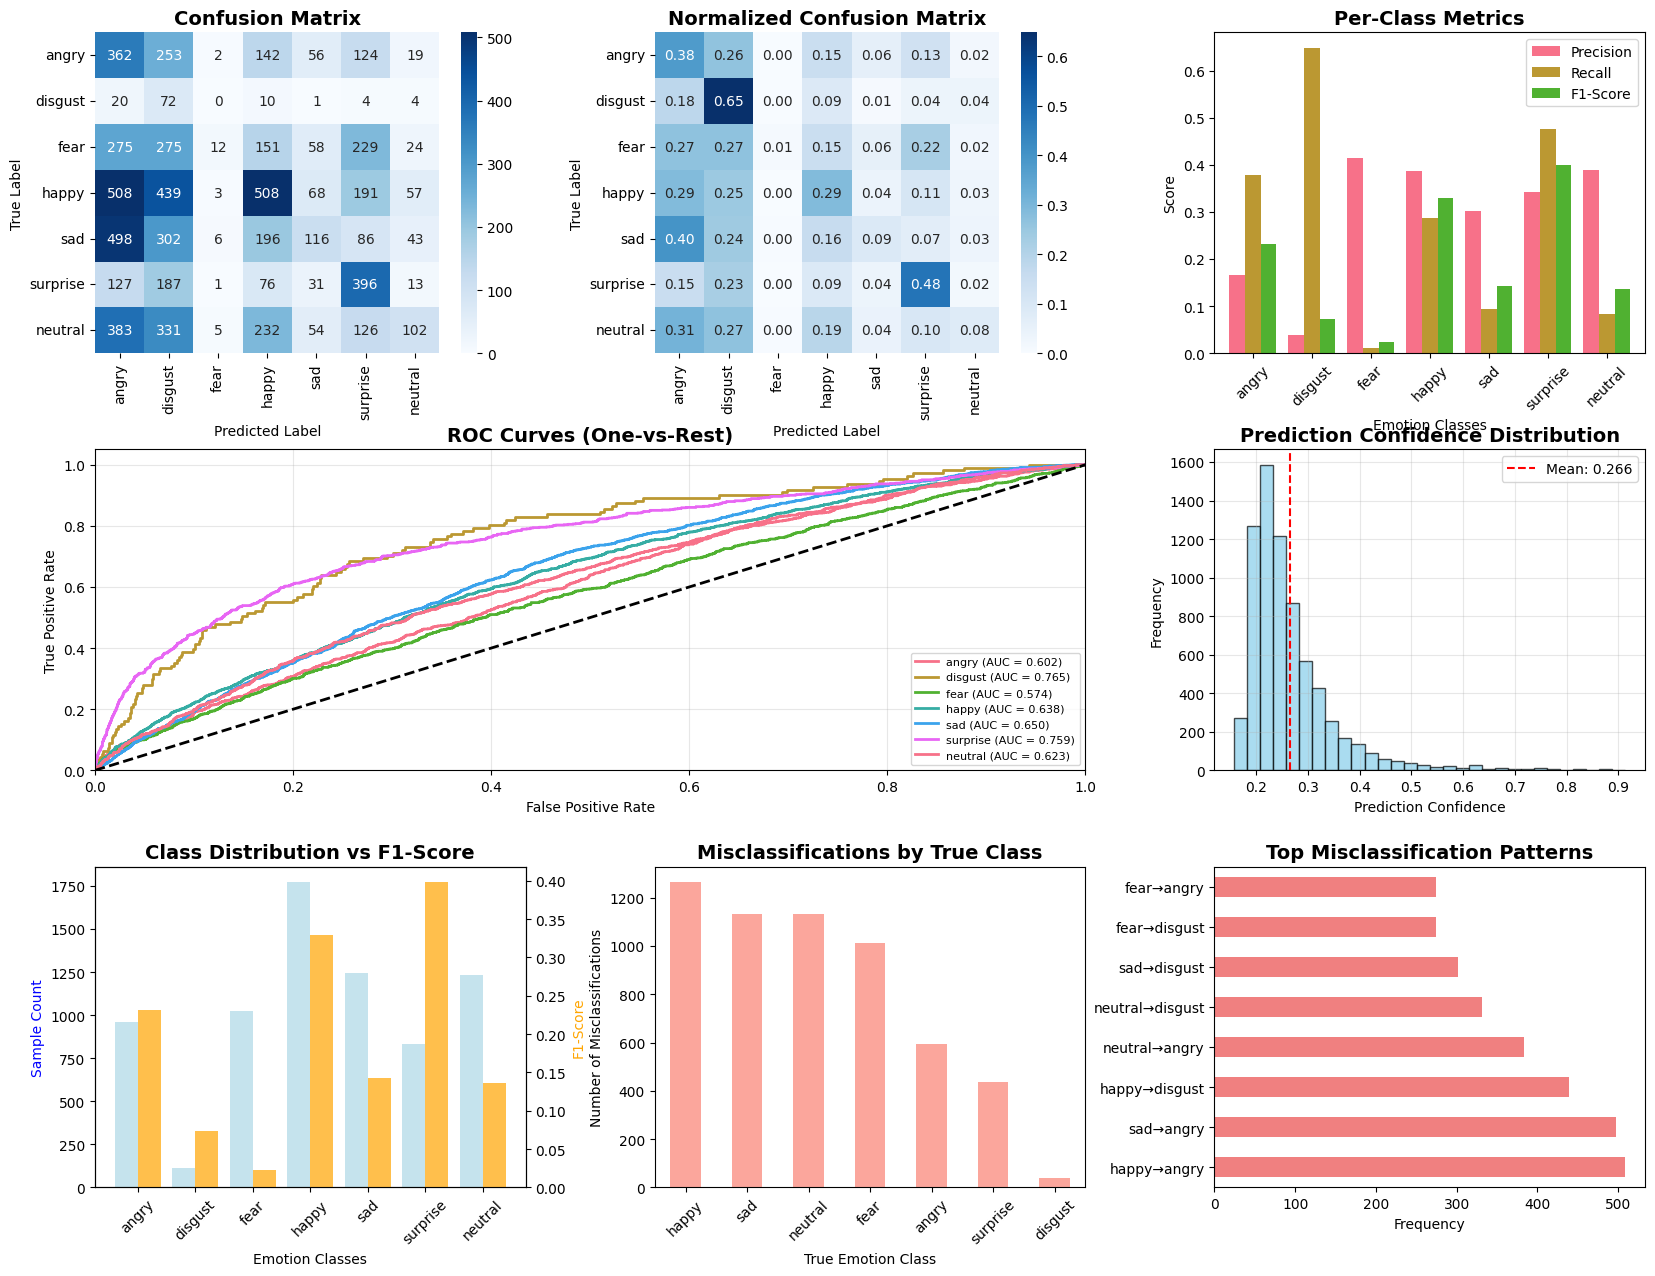

\n=== ADDITIONAL INSIGHTS ===
Total misclassifications: 5610 out of 7178 (78.16%)
Average prediction confidence: 0.2661
Most confused emotion (true): happy (1266 errors)
Most common misclassification: happy→angry (508 times)


In [15]:
def evaluate_model_comprehensive(model, test_ds, test_df, class_names):
    """
    Comprehensive model evaluation with multiple metrics and visualizations
    """
    # Get predictions
    print("Generating predictions on test set...")
    predictions = model.predict(test_ds)
    predicted_classes = np.argmax(predictions, axis=1)
    true_labels = test_df['label'].values
    
    # Calculate metrics
    test_loss, test_accuracy, test_top_k = model.evaluate(test_ds, verbose=0)
    
    print(f"\\n=== MODEL PERFORMANCE SUMMARY ===")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Top-K Accuracy: {test_top_k:.4f}")
    
    # Classification Report
    print(f"\\n=== DETAILED CLASSIFICATION REPORT ===")
    report = classification_report(true_labels, predicted_classes, 
                                 target_names=class_names, 
                                 output_dict=True)
    print(classification_report(true_labels, predicted_classes, 
                              target_names=class_names))
    
    # Create comprehensive visualizations
    create_evaluation_plots(true_labels, predicted_classes, predictions, 
                          class_names, report)
    
    return report

def create_evaluation_plots(true_labels, predicted_classes, predictions, 
                          class_names, report):
    """Create comprehensive evaluation plots"""
    
    # Setup the plot grid
    fig = plt.figure(figsize=(20, 15))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Confusion Matrix
    ax1 = fig.add_subplot(gs[0, 0])
    cm = confusion_matrix(true_labels, predicted_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=ax1)
    ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Predicted Label')
    ax1.set_ylabel('True Label')
    
    # 2. Normalized Confusion Matrix
    ax2 = fig.add_subplot(gs[0, 1])
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax2)
    ax2.set_title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Predicted Label')
    ax2.set_ylabel('True Label')
    
    # 3. Per-class metrics
    ax3 = fig.add_subplot(gs[0, 2])
    metrics_df = pd.DataFrame({
        'Precision': [report[cls]['precision'] for cls in class_names],
        'Recall': [report[cls]['recall'] for cls in class_names],
        'F1-Score': [report[cls]['f1-score'] for cls in class_names]
    }, index=class_names)
    
    metrics_df.plot(kind='bar', ax=ax3, width=0.8)
    ax3.set_title('Per-Class Metrics', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Emotion Classes')
    ax3.set_ylabel('Score')
    ax3.legend(loc='upper right')
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. ROC Curves (One-vs-Rest)
    ax4 = fig.add_subplot(gs[1, :2])
    
    # Binarize the output
    y_test_bin = label_binarize(true_labels, classes=range(len(class_names)))
    n_classes = len(class_names)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        ax4.plot(fpr[i], tpr[i], linewidth=2,
                label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    ax4.plot([0, 1], [0, 1], 'k--', linewidth=2)
    ax4.set_xlim([0.0, 1.0])
    ax4.set_ylim([0.0, 1.05])
    ax4.set_xlabel('False Positive Rate')
    ax4.set_ylabel('True Positive Rate')
    ax4.set_title('ROC Curves (One-vs-Rest)', fontsize=14, fontweight='bold')
    ax4.legend(loc="lower right", fontsize=8)
    ax4.grid(True, alpha=0.3)
    
    # 5. Prediction Confidence Distribution
    ax5 = fig.add_subplot(gs[1, 2])
    max_confidence = np.max(predictions, axis=1)
    ax5.hist(max_confidence, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax5.axvline(np.mean(max_confidence), color='red', linestyle='--', 
                label=f'Mean: {np.mean(max_confidence):.3f}')
    ax5.set_xlabel('Prediction Confidence')
    ax5.set_ylabel('Frequency')
    ax5.set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Class Distribution vs Performance
    ax6 = fig.add_subplot(gs[2, 0])
    class_counts = pd.Series(true_labels).value_counts().sort_index()
    f1_scores = [report[cls]['f1-score'] for cls in class_names]
    
    x_pos = np.arange(len(class_names))
    ax6_twin = ax6.twinx()
    
    bars1 = ax6.bar(x_pos - 0.2, class_counts.values, 0.4, 
                   label='Sample Count', alpha=0.7, color='lightblue')
    bars2 = ax6_twin.bar(x_pos + 0.2, f1_scores, 0.4, 
                        label='F1-Score', alpha=0.7, color='orange')
    
    ax6.set_xlabel('Emotion Classes')
    ax6.set_ylabel('Sample Count', color='blue')
    ax6_twin.set_ylabel('F1-Score', color='orange')
    ax6.set_title('Class Distribution vs F1-Score', fontsize=14, fontweight='bold')
    ax6.set_xticks(x_pos)
    ax6.set_xticklabels(class_names, rotation=45)
    
    # 7. Misclassification Analysis
    ax7 = fig.add_subplot(gs[2, 1])
    misclassified_idx = np.where(true_labels != predicted_classes)[0]
    misclass_by_true = pd.Series([class_names[true_labels[i]] for i in misclassified_idx]).value_counts()
    
    misclass_by_true.plot(kind='bar', ax=ax7, color='salmon', alpha=0.7)
    ax7.set_title('Misclassifications by True Class', fontsize=14, fontweight='bold')
    ax7.set_xlabel('True Emotion Class')
    ax7.set_ylabel('Number of Misclassifications')
    ax7.tick_params(axis='x', rotation=45)
    
    # 8. Top Misclassification Pairs
    ax8 = fig.add_subplot(gs[2, 2])
    misclass_pairs = []
    for i in misclassified_idx:
        true_class = class_names[true_labels[i]]
        pred_class = class_names[predicted_classes[i]]
        misclass_pairs.append(f"{true_class}→{pred_class}")
    
    top_misclass = pd.Series(misclass_pairs).value_counts().head(8)
    top_misclass.plot(kind='barh', ax=ax8, color='lightcoral')
    ax8.set_title('Top Misclassification Patterns', fontsize=14, fontweight='bold')
    ax8.set_xlabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Print additional insights
    print(f"\\n=== ADDITIONAL INSIGHTS ===")
    print(f"Total misclassifications: {len(misclassified_idx)} out of {len(true_labels)} ({len(misclassified_idx)/len(true_labels)*100:.2f}%)")
    print(f"Average prediction confidence: {np.mean(max_confidence):.4f}")
    print(f"Most confused emotion (true): {misclass_by_true.index[0]} ({misclass_by_true.iloc[0]} errors)")
    print(f"Most common misclassification: {top_misclass.index[0]} ({top_misclass.iloc[0]} times)")

# Run comprehensive evaluation
evaluation_results = evaluate_model_comprehensive(model, tf_test_ds, test_df, CLASS_NAMES)

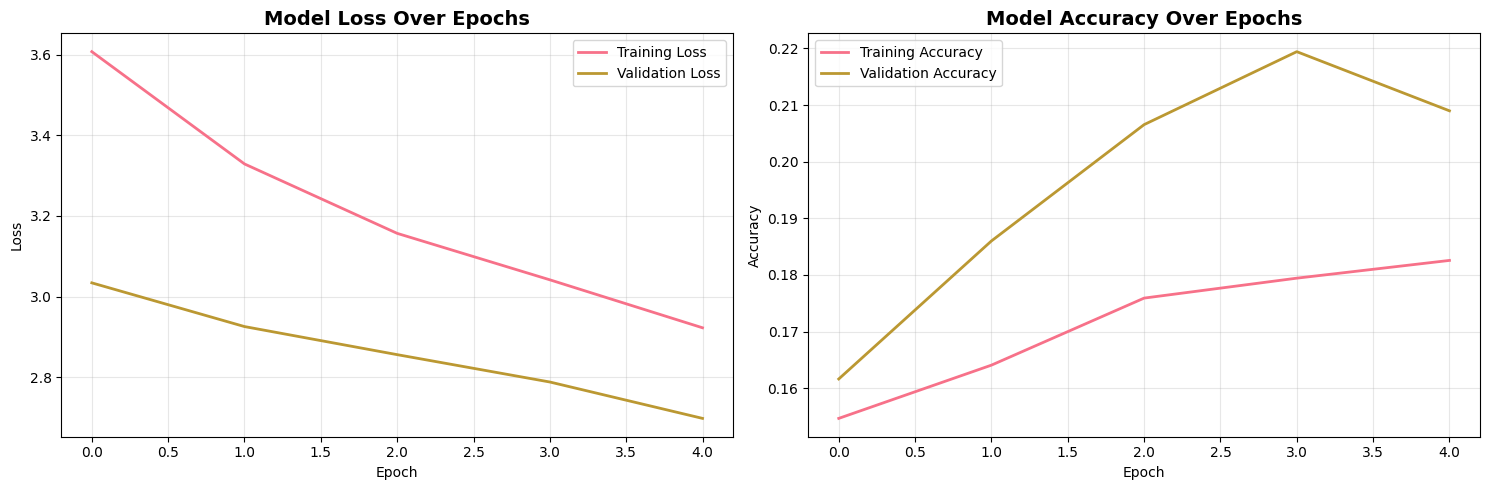

\nBest Validation Accuracy: 0.2194 (Epoch 4)
Best Validation Loss: 2.6981 (Epoch 5)


In [16]:
def plot_training_history(history):
    """Plot training history with loss and accuracy curves"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot training & validation loss
    axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot training & validation accuracy
    axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[1].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print best metrics
    best_val_acc = max(history.history['val_accuracy'])
    best_val_loss = min(history.history['val_loss'])
    best_acc_epoch = np.argmax(history.history['val_accuracy']) + 1
    best_loss_epoch = np.argmin(history.history['val_loss']) + 1
    
    print(f"\\nBest Validation Accuracy: {best_val_acc:.4f} (Epoch {best_acc_epoch})")
    print(f"Best Validation Loss: {best_val_loss:.4f} (Epoch {best_loss_epoch})")

plot_training_history(history)